#  Climate Analysis of Honolulu, Hawaii

dependencies
create a engine
conect to SQL lite local data base
run SQL Alchemy to read and save data

..done!
now..


Write Query to get data       
Plot the results in Pandas    
Create API

End.

In [151]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [152]:
import numpy as np
import pandas as pd

In [153]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [154]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [155]:
engine = create_engine("sqlite:///Resources/Hawaii.sqlite")

In [156]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [157]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [158]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [159]:
# Create our session (link) from Python to the Data Base
session = Session(engine)

inspector = inspect(engine)
inspector.get_table_names()

#Inspecting measurement

print("measurement:")
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
  
print("-------------------------")

#Inspecting station

print("station:")
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

measurement:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-------------------------
station:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Analysis

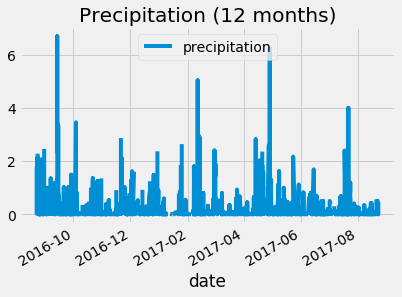

In [160]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Get the first element of the tuple
max_date = max_date[0]

# Calculate the date 1 year ago from today
# The days are equal 366 so that the first day of the year is included
year_ago = dt.datetime.strptime(max_date, "%Y-%m-%d") - dt.timedelta(days=366)


# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()



# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(query,columns=['date', 'precipitation'])

# Change datatype from element to datetime object on Pandas
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'], format='%Y-%m-%d')

# Set index to date
precipitation_df.set_index('date', inplace=True)




# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df .plot(title="Precipitation (12 months)")
plt.legend(loc='upper center')
plt.savefig("Images/Precipitation.png")
plt.show()

In [128]:
# Statitics of Data set
data.describe()

,prcp
count,1889.000000
mean,0.308274
std,0.614690
min,0.010000
25%,0.030000
50%,0.100000
75%,0.320000
max,9.640000


# Station Analysis


In [130]:
# Available Stations

available_stations = session.query(Measurement.station).distinct().count()
print(f"Stations Available: {available_stations} ")

Stations Available: 9 


In [131]:
# Most active stations?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"Most Active Stations")
active_stations

Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [132]:
# Finding most active station 

most_active_station = active_stations[0][0]
print(f"Most Active Station: {most_active_station}")


Most Active Station: USC00519281


In [133]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
print(f"Most Active Station Temperatures")
print(f"Low: {most_active_temps[0][0]} High: {most_active_temps[0][1]} Average: {round(most_active_temps[0][2], 1)}")

Most Active Station Temperatures
Low: 54.0 High: 85.0 Average: 71.7


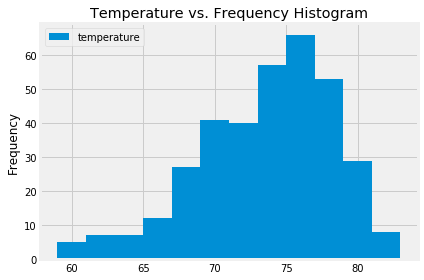

In [134]:
# Choose the station with the highest number of temperature observations.

most_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_temps_station= most_temps_station[0]



# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature_observations = session.query( Measurement.tobs).filter(Measurement.date >= year_ago).filter(Measurement.station == most_temps_station).all()
temperature_observations = pd.DataFrame(temperature_observations, columns=['temperature'])



# We need 12 bins since the observation is for twelve months

temperature_observations.plot.hist(bins=12, title="Temperature vs. Frequency Histogram")
plt.tight_layout()
plt.savefig("Images/TemperaturevsFrequency.png")
plt.show()

In [141]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-01-01','2017-01-07'))

[(62.0, 68.36585365853658, 74.0)]


In [142]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip = calc_temps('2017-01-01','2017-01-07')
trip

[(62.0, 68.36585365853658, 74.0)]

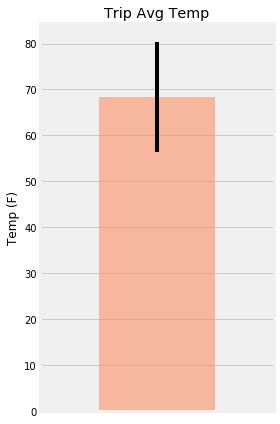

In [144]:
# Create a dataframe with the calculated tmin, tavg, and tmax values

trip_temp_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])



# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)



trip_temp_df.plot.bar(y='tavg', yerr=(trip_temp_df['tmax'] - trip_temp_df['tmin']), 
                      title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))


plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()


plt.savefig("Images/TripAvgTemp.png")
plt.show()

## Optional Challenge Assignment

In [146]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """

    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [148]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip

start_date = '2017-01-01'
end_date ='2017-01-07'


# Use the start and end date to create a range of dates
# List comprehension to get the elements in the tuple from the dates query 

dates = session.query(Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()

trip_dates = [x[0] for x in dates]




# Stip off the year and save a list of %m-%d strings with another list comprehension
# Find the start month/day and the end month/day 

trip_dates_stripped= [x[5:] for x in trip_dates]

start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]




# Loop through the list of %m-%d strings and calculate the normals for each date 

daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).group_by(func.strftime("%m-%d", Measurement.date)).all()]


daily_normals = daily_normals[0]
print("Aggregate Daily Normals for 07-01 to 07-14")
daily_normals

Aggregate Daily Normals for 07-01 to 07-14


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [149]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

# Create a dataframe from the previous query 
# Add trip_dates to Pandas DataFrame
# Change datatype from element to datetime object on Pandas, makes x axis title to add 


daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])

daily_normals_df['date']= trip_dates

daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')


# Set index to date
daily_normals_df.set_index('date',inplace=True)

daily_normals_df

,tmin,tavg,tmax
date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0


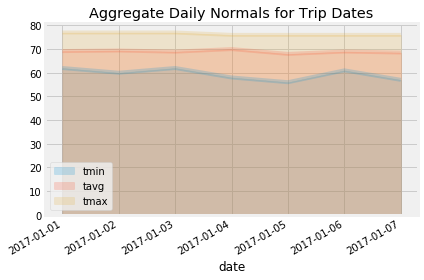

In [150]:
# Plot the daily normals as an area plot with `stacked=False`


daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()


plt.savefig("Images/DailyNormals.png")
plt.show()